### Predicted mutation effects

In [1]:
import numpy as np
import torch

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.ticker as ticker


import scipy.stats

import seaborn as sns

import config
import utils
import plot_utils

from energy_py import EnergyFunctionCalculator, energy_calc_msa, energy_calc_single
import energy_py

WT = config.WT_AA_TENSOR.numpy()

In [2]:
model_prefix = "DHFR_incl_main_kit_taq_mse"

# model that has main effect parameters averaged out
#model_prefix = "DHFR_kit_taq"

h_i_a = torch.load(f"../working/{model_prefix}_h_i_a.pt").numpy()
e_i_a_j_b = torch.load(f"../working/{model_prefix}_e_i_a_j_b.pt").numpy()
#e_i_a_j_b = e_i_a_j_b / 2.

energy_calc = EnergyFunctionCalculator(h_i_a, e_i_a_j_b)

In [3]:
WT_energy = energy_calc(WT)
WT_energy

array(0.7909182)

In [4]:
def calc_energy_mut(idx, mut_aa):
    prot_mut = WT.copy()
    prot_mut[idx] = mut_aa
    return energy_calc(prot_mut)

@config.memory.cache
def get_single_mut_energies():  
    # tuples (i, m) where i is python index 0...185 and m is 0..20 
    # Also, WT is removed. i.e. if WT[i] = m then it is removed from the 
    # list of tuples
    idx_mut_tuples = [(i, m) for m in range(config.AA_L) 
                          for i in range(config.L) if m != WT[i]]
    
    mut_df = pd.DataFrame(idx_mut_tuples, columns=["idx", "mut_aa"] )
    mut_df["energy"] = mut_df.apply(lambda row: calc_energy_mut(*row), axis=1)
    return mut_df

In [5]:
mut_df = get_single_mut_energies()
mut_df.head()

,idx,mut_aa,energy
0,0,0,0.7903765406866299
1,2,0,0.7917300873371929
2,3,0,0.7926424261976095
3,4,0,0.7935986565779345
4,5,0,0.7962956748843837


In [6]:
# sorted list of amino acids
aa_sorted = sorted(list(config.AA_MAP.keys()))
# mapping converting config.AA_MAP indexing to sorted indexing
aa_idx_to_sorted_idx = {config.AA_MAP[a]:i for i, a in enumerate(aa_sorted)}

In [7]:
# map alphabet amino acid to key using alphanumeric sorting
aa_sorted_idx_map = {a:i for i,a in enumerate(aa_sorted)}

In [8]:
mut_df["energy"] = mut_df.energy.astype(float)
mut_df["pdb_idx"] = mut_df.idx + 1
mut_df["uniprot_idx"] = mut_df.idx + 2
mut_df["energy_delta"] = mut_df.energy - WT_energy
mut_df["mut_aa_sorted"] = mut_df.mut_aa.map(aa_idx_to_sorted_idx)
mut_df["aa"] = mut_df.mut_aa_sorted.map(aa_sorted.__getitem__)
mut_df["wt_aa"] = mut_df.idx.map(config.WT_AA.__getitem__)

In [9]:
mut_df_sorted = mut_df.sort_values("energy", ascending=True)

In [10]:
mut_df_sorted.head() # Beneficial mutations

,idx,mut_aa,energy,pdb_idx,uniprot_idx,energy_delta,mut_aa_sorted,aa,wt_aa
2150,16,12,0.788245,17,18,-0.002673,0,A,G
965,102,5,0.788794,103,104,-0.002124,11,N,P
443,102,2,0.789286,103,104,-0.001632,2,D,P
2784,131,15,0.789340,132,133,-0.001578,10,M,R
1101,53,6,0.789603,54,55,-0.001316,6,H,R


In [11]:
mut_df_sorted.tail() # deleterious mutations

,idx,mut_aa,energy,pdb_idx,uniprot_idx,energy_delta,mut_aa_sorted,aa,wt_aa
978,115,5,0.802963,116,117,0.012045,11,N,G
2769,115,15,0.802964,116,117,0.012046,10,M,G
2064,115,11,0.802965,116,117,0.012047,18,W,G
631,115,3,0.802967,116,117,0.012049,3,E,G
106,115,0,0.802969,116,117,0.012051,14,R,G


In [12]:
mut_df_pivot = mut_df[["uniprot_idx", "mut_aa_sorted", "energy_delta"]].pivot(
                        "mut_aa_sorted", "uniprot_idx", "energy_delta")

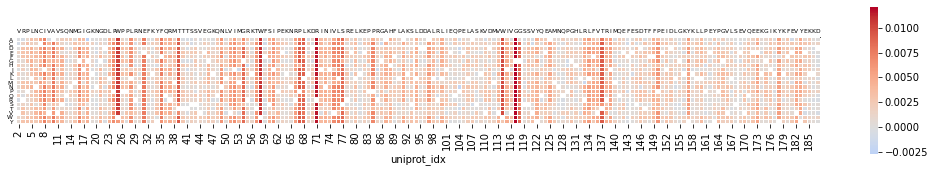

In [13]:
fig = plt.figure(figsize=(18, 3))
sns.heatmap(data=mut_df_pivot, square=True, cbar=True,
            cmap="coolwarm", center=0, linewidths=0.05,
            cbar_kws={"shrink": .90})

ax, cbar_ax = fig.get_axes()
ax.set_ylabel(None)
ax.set_ylabel(None)
ax.set_yticks(ticks=np.arange(config.AA_L) + .5)
ax.set_yticklabels(labels=aa_sorted, fontsize=6)
ax.yaxis.set_tick_params(length=0)

# label WT on the top
ax_t = ax.secondary_xaxis('top')
ax_t.set_xticks(ticks=np.arange(config.L) + 0.5)
ax_t.set_xticklabels(labels=list(config.WT_AA), fontsize=6)
ax_t.xaxis.set_tick_params(length=0)


plt.savefig(f"{config.ASSETS_DIR}/mutation_prediction.png", dpi=300)
plt.savefig(f"{config.ASSETS_DIR}/mutation_prediction.eps")
pass

## EVE

In [14]:
eve_df = pd.read_csv("../DHFR/uniprot/EVE/mDHFR_20000_samples.csv")
eve_df = eve_df[eve_df.mutations != "wt"] # drop the WT row as it is zero

eve_df["wt_aa"] = eve_df.mutations.str.get(0)
eve_df["aa"] = eve_df.mutations.str.get(-1)
eve_df["uniprot_idx"] = eve_df.mutations.str.slice(1,-1).astype(int)
eve_df["mut_aa_sorted"] = eve_df.aa.map(aa_sorted_idx_map)
eve_df["evol_indices"] *= -1
eve_df.head()

,protein_name,mutations,evol_indices,wt_aa,aa,uniprot_idx,mut_aa_sorted
1,mDHFR,V2A,-0.091125,V,A,2,0
2,mDHFR,V2C,-0.261230,V,C,2,1
3,mDHFR,V2D,-0.323608,V,D,2,2
4,mDHFR,V2E,11.718536,V,E,2,3
5,mDHFR,V2F,-0.345947,V,F,2,4


In [15]:
eve_df_pivot = eve_df[["uniprot_idx", "mut_aa_sorted", "evol_indices"]].pivot(
                            "mut_aa_sorted", "uniprot_idx", "evol_indices")

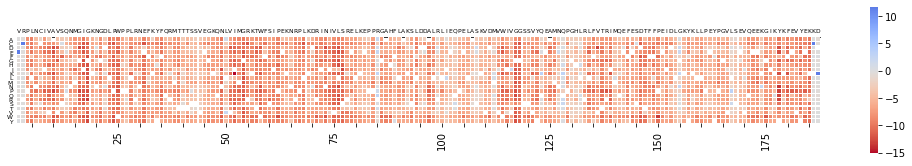

In [16]:
fig = plt.figure(figsize=(18, 3))
sns.heatmap(data=eve_df_pivot, square=True, cbar=True,
            cmap="coolwarm_r", center=0, linewidths=0.05,
            cbar_kws={"shrink": .90})

ax, cbar_ax = fig.get_axes()
ax.set_ylabel(None)
ax.set_ylabel(None)
ax.set_yticks(ticks=np.arange(config.AA_L) + .5)
ax.set_yticklabels(labels=aa_sorted, fontsize=6)
ax.yaxis.set_tick_params(length=0)

# put tick in the middle of the box (offset = 0.5)
ax.set_xticks(ticks=(np.arange(186) + 0.5)[3:-1:5])
# uniprot indexing goes from 2 to 187 so we add 2
ax.set_xticklabels((np.arange(186) + 2)[3:-1:5], rotation=90)

# only keep every 5th ticklabel visible
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if (i+1) % 5 != 0]

ax.set_xlabel(None)

# label WT on the top
ax_t = ax.secondary_xaxis('top')
ax_t.set_xticks(ticks=np.arange(config.L) + 0.5)
ax_t.set_xticklabels(labels=list(config.WT_AA), fontsize=6)
ax_t.xaxis.set_tick_params(length=0)

plt.savefig(f"{config.ASSETS_DIR}/EVE_prediction.png", dpi=300)
plt.savefig(f"{config.ASSETS_DIR}/EVE_prediction.eps")

In [17]:
mut_merge = pd.merge(eve_df, mut_df, left_on=["uniprot_idx", "mut_aa_sorted"], 
                     right_on=["uniprot_idx", "mut_aa_sorted"])
mut_merge.energy_delta *= (-400)

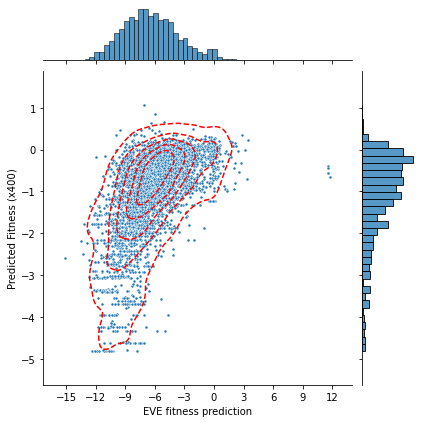

In [18]:
g = sns.jointplot(data=mut_merge[["evol_indices", "energy_delta"]], 
             x="evol_indices", y="energy_delta", marker=".")
g.plot_joint(sns.kdeplot, color="r", linestyles="--", zorder=1, levels=6)
g.set_axis_labels("EVE fitness prediction", "Predicted Fitness (x400)")
import matplotlib.ticker as ticker
g.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(3))

plt.savefig(f"{config.ASSETS_DIR}/EVE_vs_trajectory.png", dpi=300)
plot_utils.save_eps_file(f"{config.ASSETS_DIR}/EVE_vs_trajectory.eps")
pass

In [19]:
scipy.stats.spearmanr(mut_merge.evol_indices, mut_merge.energy_delta)

SpearmanrResult(correlation=0.6238938682725451, pvalue=0.0)

## EVmutation

In [20]:
evmut_df = pd.read_csv("../DHFR/uniprot/EVmutation/mDHFR_EVmutation.csv")
evmut_df.head()

,mutant,pos,wt,subs,frequency,effect_prediction_epistatic
0,V1A,1,V,A,0.0,-8.458207
1,V1C,1,V,C,0.0,-8.458207
2,V1D,1,V,D,0.0,-8.458207
3,V1E,1,V,E,0.0,-8.458207
4,V1F,1,V,F,0.0,-8.458207


In [21]:
evmut_df["mut_aa_sorted"] = evmut_df.subs.map(aa_sorted_idx_map)
evmut_df["uniprot_idx"] = evmut_df.pos + 1

In [22]:
evmut_df_pivot = evmut_df[["uniprot_idx", "mut_aa_sorted", "effect_prediction_epistatic"]].pivot(
                            "mut_aa_sorted", "uniprot_idx", "effect_prediction_epistatic")

In [23]:
evmut_df_pivot

uniprot_idx,2,3,4,5,6,7,8,9,10,11,...,178,179,180,181,182,183,184,185,186,187
mut_aa_sorted,,,,,,,,,,,,,,,,,,,,,
0,-8.458207,-8.458207,-7.598497,-10.747801,-5.396393,-2.526045,-6.324938,-2.167535,NaN,-2.746517,...,-7.893420,-4.867958,-8.008045,-6.348045,-9.204670,-9.464926,-6.098509,-10.886656,-8.458207,-8.458207
1,-8.458207,-8.458207,-7.598497,-10.747801,-5.808736,NaN,-7.548298,-6.072531,-6.593426,-4.711372,...,-6.706256,-5.641660,-6.680982,-3.692041,-8.682187,-7.284966,-7.384794,-10.886656,-8.458207,-8.458207
2,-8.458207,-8.458207,-7.598497,-10.747801,-5.620467,-9.912311,-8.323562,-10.069299,-10.620631,-10.927818,...,-9.965719,-6.515959,-8.999055,-6.651888,-9.143873,-11.452726,-4.478109,-10.886656,-8.458207,NaN
3,-8.458207,-8.458207,-2.768377,-10.747801,-5.085270,-8.201579,-9.643568,-8.328640,-10.493427,-6.866884,...,-11.556842,-4.193784,-9.733646,NaN,-8.337196,-11.452726,NaN,-10.886656,-8.458207,-8.458207
4,-8.458207,-8.458207,-7.598497,-3.964151,-6.830783,-6.877154,-6.116419,-5.956600,-9.481162,-7.030479,...,-3.603916,-5.869555,NaN,-5.831276,-8.295507,-4.308137,-8.672620,-10.886656,-8.458207,-8.458207
5,-8.458207,-8.458207,-7.598497,-10.747801,-6.071170,-4.242151,-8.586236,-6.612966,-7.209524,-7.428141,...,-8.094592,-5.471394,-9.338217,-7.737568,-8.763364,-11.452726,-6.400561,-10.886656,-8.458207,-8.458207
6,-8.458207,-8.458207,-7.598497,-10.747801,-5.699099,-6.482066,-8.173287,-10.451160,-8.688896,-7.094668,...,-4.983255,-4.538211,-6.052546,-5.147838,-8.930716,-7.344977,-5.916452,-7.152465,-8.458207,-8.458207
7,-8.458207,-8.458207,-7.598497,-2.775996,-5.704617,-3.773820,NaN,-4.569259,-7.990279,-4.000000,...,-6.041586,-5.028478,-7.102927,-6.520206,-4.932157,-8.477848,-5.088041,-10.886656,-8.458207,-8.458207
8,-8.458207,-8.458207,-0.621109,-10.747801,-4.186597,-9.912311,-8.241427,-10.451160,-11.922343,-7.046606,...,-11.556842,NaN,-10.003912,-5.171105,-7.793069,-9.415955,-3.809947,NaN,NaN,-8.458207


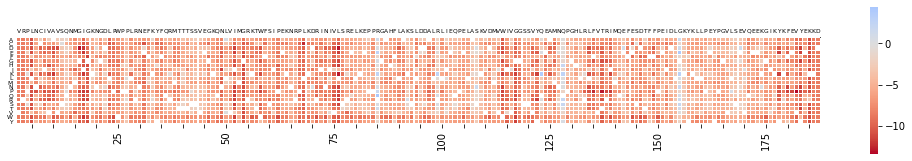

In [24]:
fig = plt.figure(figsize=(18, 3))
sns.heatmap(data=evmut_df_pivot, square=True, cbar=True,
            cmap="coolwarm_r", center=0, linewidths=0.05,
            cbar_kws={"shrink": .90})

ax, cbar_ax = fig.get_axes()
ax.set_ylabel(None)
ax.set_ylabel(None)
ax.set_yticks(ticks=np.arange(config.AA_L) + .5)
ax.set_yticklabels(labels=aa_sorted, fontsize=6)
ax.yaxis.set_tick_params(length=0)

# put tick in the middle of the box (offset = 0.5)
ax.set_xticks(ticks=(np.arange(186) + 0.5)[3:-1:5])
# uniprot indexing goes from 2 to 187 so we add 2
ax.set_xticklabels((np.arange(186) + 2)[3:-1:5], rotation=90)

# only keep every 5th ticklabel visible
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if (i+1) % 5 != 0]

ax.set_xlabel(None)

# label WT on the top
ax_t = ax.secondary_xaxis('top')
ax_t.set_xticks(ticks=np.arange(config.L) + 0.5)
ax_t.set_xticklabels(labels=list(config.WT_AA), fontsize=6)
ax_t.xaxis.set_tick_params(length=0)

plt.savefig(f"{config.ASSETS_DIR}/EVmutation_prediction.png", dpi=300)
plt.savefig(f"{config.ASSETS_DIR}/EVmutation_prediction.eps")

In [25]:
mut_merge = pd.merge(evmut_df, mut_df, left_on=["uniprot_idx", "mut_aa_sorted"], 
                     right_on=["uniprot_idx", "mut_aa_sorted"])
# reverse sign to match up with evmutation's convention
mut_merge.energy_delta = - 400 * mut_merge.energy_delta
mut_merge.head()

,mutant,pos,wt,subs,frequency,effect_prediction_epistatic,mut_aa_sorted,uniprot_idx,idx,mut_aa,energy,pdb_idx,energy_delta,aa,wt_aa
0,V1A,1,V,A,0.0,-8.458207,0,2,0,12,0.790708,1,0.083942,A,V
1,V1C,1,V,C,0.0,-8.458207,1,2,0,9,0.790181,1,0.294984,C,V
2,V1D,1,V,D,0.0,-8.458207,2,2,0,2,0.791052,1,-0.053523,D,V
3,V1E,1,V,E,0.0,-8.458207,3,2,0,3,0.792556,1,-0.654970,E,V
4,V1F,1,V,F,0.0,-8.458207,4,2,0,16,0.791574,1,-0.262480,F,V


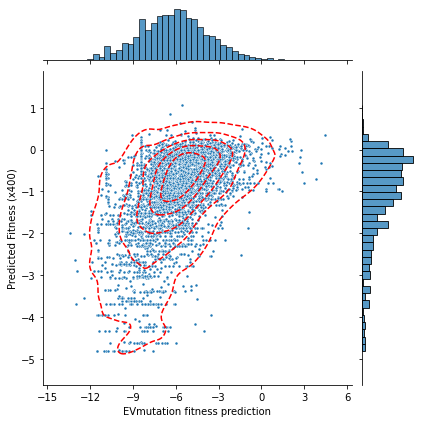

In [26]:
g = sns.jointplot(data=mut_merge[["effect_prediction_epistatic", "energy_delta"]], 
             x="effect_prediction_epistatic", y="energy_delta", marker=".")
g.plot_joint(sns.kdeplot, color="r", linestyles="--", zorder=1, levels=6)
g.set_axis_labels("EVmutation fitness prediction", "Predicted Fitness (x400)")
import matplotlib.ticker as ticker
g.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(3))

plt.savefig(f"{config.ASSETS_DIR}/EVmutation_vs_trajectory.png", dpi=300)
plot_utils.save_eps_file(f"{config.ASSETS_DIR}/EVmutation_vs_trajectory.eps")
pass

In [27]:
scipy.stats.spearmanr(mut_merge.effect_prediction_epistatic, mut_merge.energy_delta)

SpearmanrResult(correlation=0.540900574143799, pvalue=8.546304419510188e-268)

In [28]:
# Take absolute value and then find the mean
energy_mean_df = mut_df.groupby("idx").agg(
    energy_mean = ('energy_delta', lambda x: np.mean(np.abs(x)))).reset_index()

energy_mean_df["pdb_idx"] = energy_mean_df.idx + 1
energy_mean_df["uniprot_idx"] = energy_mean_df.idx + 2

energy_mean_df.to_csv(f"{config.ASSETS_DIR}/mutation_prediction_averaged.csv")
energy_mean_df.head()

,idx,energy_mean,pdb_idx,uniprot_idx
0,0,0.000796,1,2
1,1,0.001894,2,3
2,2,0.002110,3,4
3,3,0.003086,4,5
4,4,0.002853,5,6


In [29]:
print(f"min avg abs energy = {energy_mean_df.energy_mean.min():.2e}, "
      f"max avg abs energy = {energy_mean_df.energy_mean.max():.2e}")

min avg abs energy = 3.46e-04, max avg abs energy = 1.20e-02


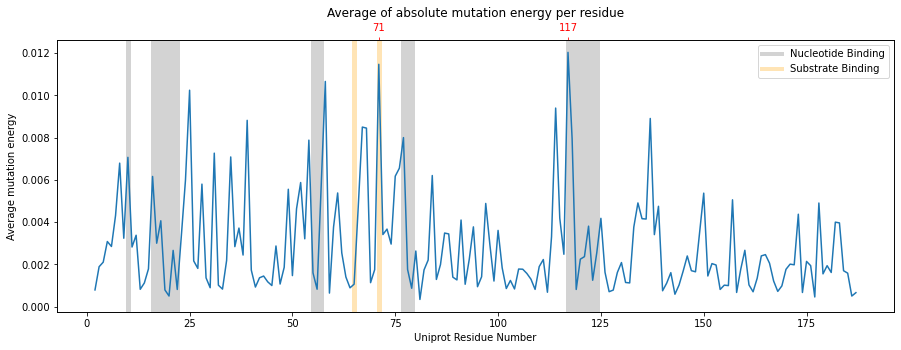

In [30]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='uniprot_idx', y='energy_mean', data=energy_mean_df)
ax.set_xlabel("Uniprot Residue Number")
ax.set_ylabel("Average mutation energy")
ax.set_title("Average of absolute mutation energy per residue")

# nucleotide binding in https://www.uniprot.org/uniprot/P00375
for start, end in [(10,10), (16,22), (55,57), (77,79), (117,124)]:
    ax.axvspan(start - 0.5, end + 0.5, color='lightgray')
    
for start, end in [(65,65), (71,71)]:
    ax.axvspan(start - 0.5, end + 0.5, color='moccasin')    
    
legend_lines = [lines.Line2D([0], [0], color="lightgray", lw=4),
                lines.Line2D([0], [0], color="moccasin", lw=4)
               ]
ax.legend(legend_lines, ['Nucleotide Binding', 'Substrate Binding'])

ax_t = ax.twiny()
ax_t.set_xlim(ax.get_xlim())
ax_t.set_xticks([71, 117])
ax_t.tick_params(axis='x', colors='red')


pass